In [0]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np


In [0]:
img_shape = (28,28,1)
batch_size = 16
latent_dim = 2

In [0]:
input_img = keras.Input(shape = img_shape)
x = layers.Conv2D(32,3,padding='same',activation='relu')(input_img)
x = layers.Conv2D(64,3,padding='same',activation='relu',strides=(2,2))(x)
x = layers.Conv2D(64,3,padding='same',activation='relu')(x)
x = layers.Conv2D(64,3,padding='same',activation='relu')(x)
shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(32,activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)  # The input encoded in these two vectors

In [38]:
K.int_shape(input_img)

(None, 28, 28, 1)

In [39]:
shape_before_flattening

(None, 14, 14, 64)

In [40]:
K.int_shape(z_mean)

(None, 2)

In [0]:
# Latent space sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=1.)
    
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

In [42]:
K.int_shape(z)

(None, 2)

In [0]:
# VAE Decoder network
decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]),activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32,3,padding='same',activation='relu',strides=(2,2))(x)
x = layers.Conv2D(1,3,padding='same',activation='sigmoid')(x)


In [0]:
encoder = Model(input_img,[z_mean,z_log_var])
decoder = Model(decoder_input,x)
z_decoded = decoder(z)

In [45]:
K.int_shape(z_decoded)

(None, 28, 28, 1)

In [0]:
# CAlculating loss using a keras layer
class CustomVariationalLayer(keras.layers.Layer):
    def vae_loss(self,x,z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss+kl_loss)
    def call(self,inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x,z_decoded)
        self.add_loss(loss,inputs=inputs)
        return x

In [0]:
y = CustomVariationalLayer()([input_img,z_decoded])

In [48]:
from tensorflow.keras.datasets import mnist

vae = Model(input_img,y)
vae.compile(optimizer='rmsprop',loss=None)
vae.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 28, 28, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_7[0][0]                   
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output custom_variational_layer_2 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_2.
  'be expecting any data to be passed to {0}.'.format(name))


In [0]:
(x_train,_),(x_test,t_test) = mnist.load_data()

In [50]:
x_train.shape

(60000, 28, 28)

In [0]:
x_train = x_train.astype('float32')/255.
x_train = x_train.reshape(x_train.shape+(1,))
x_test = x_test.astype('float32')/255.
x_test = x_test.reshape(x_test.shape+(1,))

In [52]:
x_train.shape

(60000, 28, 28, 1)

In [53]:
vae.fit(x=x_train,y=None,shuffle=True,epochs=10,batch_size=batch_size,validation_data=(x_test,None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 21s 353us/step - loss: 0.2300 - val_loss: 0.1967
Epoch 2/10
60000/60000 [==============================] - 21s 346us/step - loss: 0.1939 - val_loss: 0.1901
Epoch 3/10
60000/60000 [==============================] - 21s 356us/step - loss: 0.1890 - val_loss: 0.1885
Epoch 4/10
60000/60000 [==============================] - 21s 345us/step - loss: 0.1862 - val_loss: 0.1856
Epoch 5/10
60000/60000 [==============================] - 21s 346us/step - loss: 0.1844 - val_loss: 0.1836
Epoch 6/10
60000/60000 [==============================] - 21s 345us/step - loss: 0.1831 - val_loss: 0.1852
Epoch 7/10
60000/60000 [==============================] - 21s 342us/step - loss: 0.1821 - val_loss: 0.1830
Epoch 8/10
60000/60000 [==============================] - 21s 347us/step - loss: 0.1811 - val_loss: 0.1808
Epoch 9/10
60000/60000 [==============================] - 21s 348us/step - loss: 0.1806 - val_

In [0]:
# Then we can use the decoder network to turn latent space to images
import matplotlib.pyplot as plt
from scipy.stats import norm

n=15
digit_size = 28
figure = np.zeros((digit_size*n,digit_size*n))
grid_x = norm.ppf(np.linspace(0.05,0.95,n))
grid_y = norm.ppf(np.linspace(0.05,0.95,n))


In [55]:
np.linspace(0.05,0.95,n)

array([0.05      , 0.11428571, 0.17857143, 0.24285714, 0.30714286,
       0.37142857, 0.43571429, 0.5       , 0.56428571, 0.62857143,
       0.69285714, 0.75714286, 0.82142857, 0.88571429, 0.95      ])

In [56]:
grid_x

array([-1.64485363e+00, -1.20404696e+00, -9.20822976e-01, -6.97141435e-01,
       -5.03965367e-01, -3.28072108e-01, -1.61844167e-01, -1.39145821e-16,
        1.61844167e-01,  3.28072108e-01,  5.03965367e-01,  6.97141435e-01,
        9.20822976e-01,  1.20404696e+00,  1.64485363e+00])

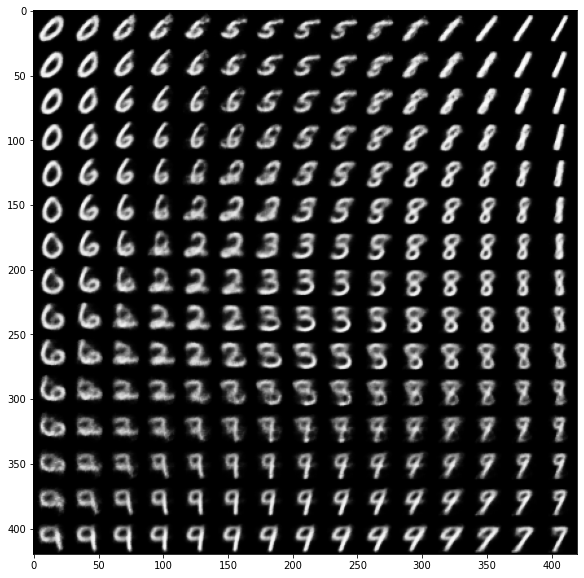

In [57]:
for i,yi in enumerate(grid_x):
    for j,xi in enumerate(grid_y):
        z_sample = np.array([[xi,yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample,batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size,digit_size)
        figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10,10))
plt.imshow(figure,cmap='Greys_r')
plt.show()

In [98]:
z_sample = np.array([[0,0]])
#z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
z_sample.shape

(1, 2)

In [99]:
x_decoded = decoder.predict(z_sample,batch_size=1)
x_decoded.shape

(1, 28, 28, 1)

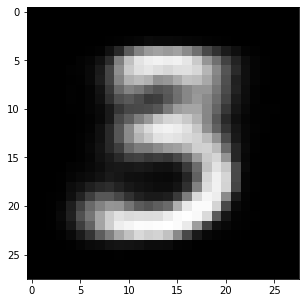

In [100]:
digit = x_decoded.reshape(digit_size,digit_size)
plt.figure(figsize=(5,5))
plt.imshow(digit,cmap='Greys_r')
plt.show()

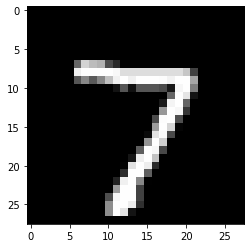

In [90]:
test = x_test[0]
test = test.reshape(digit_size,digit_size)
plt.imshow(test,cmap='Greys_r')

In [0]:
test = x_test[0]
test = np.expand_dims(test,axis=0)
mean,log_var = encoder.predict(test,batch_size=1)

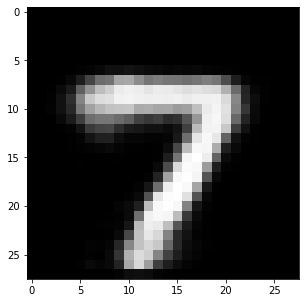

In [93]:
test_decoded = decoder.predict(mean,batch_size=1)
test_decoded = test_decoded.reshape(digit_size,digit_size)
plt.figure(figsize=(5,5))
plt.imshow(test_decoded,cmap='Greys_r')
plt.show()

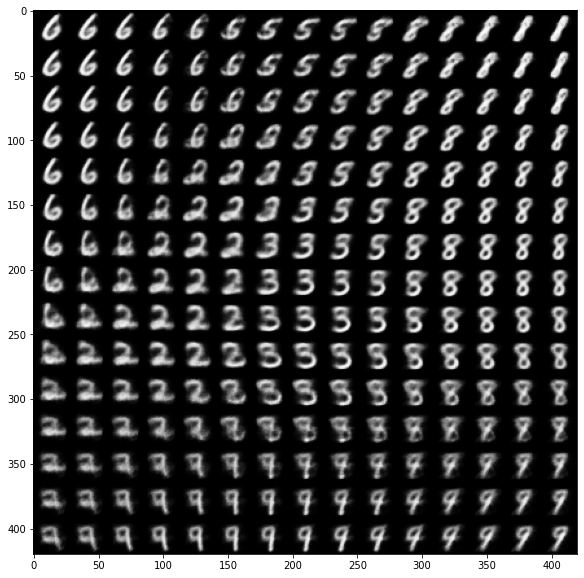

In [101]:
# Then we can use the decoder network to turn latent space to images
import matplotlib.pyplot as plt
from scipy.stats import norm

n=15
digit_size = 28
figure = np.zeros((digit_size*n,digit_size*n))
grid_x = np.linspace(-1,1,n)
grid_y = np.linspace(-1,1,n)

for i,yi in enumerate(grid_x):
    for j,xi in enumerate(grid_y):
        z_sample = np.array([[xi,yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample,batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size,digit_size)
        figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10,10))
plt.imshow(figure,cmap='Greys_r')
plt.show()